In [1]:
import numpy as np, os, sys
from team_code import load_model, run_model_2, X_rawecg, X_dwt, X_pan_tomkins
from helper_code import *

2025-08-20 15:03:43.032862: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-20 15:03:43.049963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755669823.070548 2019603 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755669823.077134 2019603 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-20 15:03:43.098644: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
data = np.load('ecg_test_data.npz', allow_pickle=True)

X_test_all = data['X']
y_test_all = data['y']

# 확인
print(type(X_test_all), type(X_test_all[0]))  # <class 'numpy.ndarray'> <class 'numpy.ndarray'>
print(X_test_all[0].shape)  # 예: (5000, 12)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(12, 5000)


In [3]:
data_2 = np.load('ecg_val_data.npz', allow_pickle=True)

X_val_all = data_2['X']
y_val_all = data_2['y']

# 확인
print(type(X_val_all), type(X_val_all[0]))  # <class 'numpy.ndarray'> <class 'numpy.ndarray'>
print(X_val_all[0].shape)  # 예: (5000, 12)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(12, 5000)


In [4]:
import re

# Define the Challenge lead sets. These variables are not required. You can change or remove them.
twelve_leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')
six_leads = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF')
four_leads = ('I', 'II', 'III', 'V2')
three_leads = ('I', 'II', 'V2')
two_leads = ('I', 'II')
lead_sets = (twelve_leads, six_leads, four_leads, three_leads, two_leads)
filters = ['Raw', 'DWT', 'PT']

def test_single_case( model_path, data, best_th ,selected_filter, selected_leads):
    results = {}

    num_leads = len(selected_leads)
    
    # 모델 로드 및 실행
    current_model = load_model(model_path)
    i = filters.index(selected_filter)

    if i ==  0 :
        data_filtered = X_rawecg(data, num_leads)
        print("filtering complete")

    if i ==  1 :
        data_filtered = X_dwt(data, num_leads)
        print("filtering complete")

    if i ==  2 :
        data_filtered = X_pan_tomkins(data, num_leads)
        print("filtering complete")

    binary_prediction, probabilities = run_model_2(current_model, data_filtered, num_leads,  best_th)
    
    
    # 결과 저장
    results[selected_filter] = {
        f'leads_{num_leads}': {
            'binary_prediction': binary_prediction,
            'probabilities': probabilities
        }
    }
    print('Done.')

    return results

def validate_single_case(model_path,
                         val_data,           # ECG 녹화 데이터 리스트  (N, …)
                         val_labels,         # one-hot 또는 multi-hot  (N, C)
                         selected_filter,    # 'raw', 'dwt', 'pt' 등
                         selected_leads,     # 사용하려는 리드 튜플
                         init_th=None):      # 첫 호출 시 None → 전부 0으로 세팅
    """
    validation set으로부터 클래스별 F1-score가 가장 높은 threshold를 계산해 반환
    Returns
    -------
    best_thresholds : np.ndarray, shape (C,)
        클래스별 최적 threshold (소수점 4째 자리 반올림)
    best_f1_scores  : np.ndarray, shape (C,)
        각 threshold에 대응하는 F1-score (정보용)
    """

    num_leads   = len(selected_leads)
    num_classes = val_labels.shape[1]

    # 1) 모델 로드
    model = load_model(model_path)
    i = filters.index(selected_filter)

    if i ==  0 :
        data_filtered = X_rawecg(val_data, num_leads)
        print("filtering complete")

    if i ==  1 :
        data_filtered = X_dwt(val_data, num_leads)
        print("filtering complete")

    if i ==  2 :
        data_filtered = X_pan_tomkins(val_data, num_leads)
        print("filtering complete")

    # 2) validation 세트에 대한 확률 예측
    dummy_th = init_th if init_th is not None else [0.0] * num_classes
    _, prob_list = run_model_2(model,
                             data_filtered,
                             num_leads,
                             dummy_th)                    
    probs = np.vstack(prob_list).squeeze()            

    # 3) 클래스별 threshold 탐색
    best_thresholds = np.zeros(num_classes, dtype=np.float32)
    best_f1_scores  = np.zeros(num_classes, dtype=np.float32)

    for c in range(num_classes):
        y_true = val_labels[:, c]
        y_prob = probs[:, c]

        # precision_recall_curve가 리턴하는 threshold 후보 이용
        precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
        f1_vals = 2 * precision * recall / (precision + recall + 1e-8)
        best_idx = int(np.nanargmax(f1_vals))
        th_star  = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

        best_thresholds[c] = th_star
        best_f1_scores[c]  = f1_vals[best_idx]

    # 소수점 4째 자리로 통일
    best_thresholds = np.round(best_thresholds, 4)

    return best_thresholds, best_f1_scores


# def test_model(model_path, data_files, filters, lead_sets):
#     results = {}
#     for i, f in enumerate(filters):
#         for leads in lead_sets:
#             num_leads = len(leads)
#             model_name = f"{f}_model_{num_leads}_leads.h5"
            
#             # 모델 로드 및 실행
#             print(f'Running model {model_name}...')
#             current_model = load_model(model_path, model_name)
#             binary_prediction, probabilities = run_model(current_model, data_files, num_leads, i)
            
#             # 결과 저장
#             filter_results = results.setdefault(f, {})
#             filter_results[f'leads_{num_leads}'] = {
#                 'binary_prediction': binary_prediction,
#                 'probabilities': probabilities
#             }
#             print('Done.')

#     return results

# # Define the paths
# model_path = 'C:\\Users\\medai01\\Desktop\\ecg\\model'

# # Run the test
# result = test_model(model_path, test_files, filters, lead_sets)

# Define the paths
# model_path = 'D:\\physionet.org\\model_1\\12_leads_rythm'

# # 원하는 필터와 리드 세트 선택
# selected_filter = 'Normal'  # 테스트할 필터 지정 
# selected_leads = twelve_leads  # 테스트할 리드 개수 지정
# epoch = 14
# val = '0.70'

# # Run the single test case
# result = test_single_case(model_path, test_files, selected_filter, selected_leads, epoch, val)

In [5]:
# def test_all_models_2(folder_path):
#     model_dict = {}  

#     lead_folders = ["12_leads_rythm", "6_leads_rythm", "4_leads_rythm", "3_leads_rythm", "2_leads_rythm"]

#     # lr 값은 무시하고, valf1만 추출
#     pattern = re.compile(r"^(\w+)_model_(\d+)_leads_lr(?:[\d.]+)_e(\d+)_valf1([\d.]+).h5$")
    
#     for folder in lead_folders:
#         target_leads = int(folder.split("_")[0])
#         for file in os.listdir(folder_path):

#             if not file.endswith(".h5"):
#                 continue

#             m = pattern.match(file)
#             if not m:
#                 continue

#             selected_filter, model_leads, epoch_str, val_str = m.groups()
#             epoch = int(epoch_str)
#             val = float(val_str)

#             if int(model_leads) != target_leads:
#                 continue

#             key = (selected_filter, target_leads)
#             if key not in model_dict or model_dict[key]["val"] < val:
#                 model_dict[key] = {
#                     "val": val,
#                     "file": file,
#                     "epoch": epoch
#                 }

#     # 결과: 최대 valf1 모델 파일명만 출력
#     for (selected_filter, num_leads), info in model_dict.items():
#         print(f"Max F1 model for {num_leads} leads ({selected_filter}): {info['file']} (valf1={info['val']})")

# with tf.device('/device:GPU:1'):
#     if __name__ == "__main__":
#         base_path = r"/home/shjee/projects/ecg1d/model"
#         test_all_models_2(base_path)


In [6]:
import re

def test_all_models_2(folder_path, test_data, val_data, val_label ):
    
    # th_df = pd.read_excel(th_path)

    results = {}
    model_dict = {}  

    # 순회할 폴더 리스트
    lead_folders = ["12_leads_rythm", "6_leads_rythm", "4_leads_rythm", "3_leads_rythm", "2_leads_rythm"]

    pattern = re.compile(r"^(\w+)_model_(\d+)_leads_lr(?:[\d.]+)_e(\d+)_valf1([\d.]+).h5$")
    for folder in lead_folders:
        target_leads = int(folder.split("_")[0])
        for file in os.listdir(folder_path):

            if not file.endswith(".h5"):
                continue

            m = pattern.match(file)

            if not m:
                continue

            selected_filter, model_leads, epoch_str, val_str = m.groups()
            epoch = int(epoch_str)
            val = float(val_str)
            
            if int(model_leads) != target_leads:
                continue

            key = (selected_filter, target_leads)
            if key not in model_dict or model_dict[key]["val"] < val:
                model_dict[key] = {
                    "val": val,
                    "file": file,
                    "epoch": epoch
                }

    # 3) 선별된 모델들 테스트
    for (selected_filter, num_leads), info in model_dict.items():
        file = info["file"]
        epoch = info["epoch"]
        val = info["val"]
        model_path = os.path.join(folder_path, file)

        if not os.path.isfile(model_path):
            print(f"File not found: {model_path}")
            continue
        print(f"Testing {file} (epoch {epoch}, valf1={val})…")

        try:

            '''best thresthold 선정 과정'''
            # best_th = th_df.iloc[epoch - 1].tolist()
            # th = 0.15
            # best_th = [th for _ in range(23)]

            best_th, _ = validate_single_case(
                model_path,
                val_data,
                val_label,
                selected_filter,
                list(range(num_leads))
            )
            print(f'best_th : {best_th}')

        except IndexError:
            raise ValueError(f"validation으로 검증된 threthold가 존재하지 않습니다.")

        # test_single_case에 넘겨주기
        
        result = test_single_case(
            model_path,
            test_data,
            best_th,
            selected_filter,
            list(range(num_leads))
        )
        results[file] = result

    return results

# with tf.device('/device:GPU:1'):
#     if __name__ == "__main__":
#         base_path = r"/home/shjee/projects/ecg1d/model"
#         all_results_2 = test_all_models_2(base_path, X_test_all, X_val_all, y_val_all)


In [7]:
# import re

# # th_path = r'C:\Users\medai01\Desktop\ecg\th_log\threshold_log.xlsx'

def test_all_models(folder_path, test_data):
    
    # th_df = pd.read_excel(th_path)

    results = {}
    model_dict = {}  

    # 순회할 폴더 리스트
    lead_folders = ["12_leads_rythm", "6_leads_rythm", "4_leads_rythm", "3_leads_rythm", "2_leads_rythm"]

    pattern = re.compile(r"^(\w+)_model_(\d+)_leads_lr(?:[\d.]+)_e(\d+)_valf1([\d.]+).h5$")
    for folder in lead_folders:
        target_leads = int(folder.split("_")[0])
        for file in os.listdir(folder_path):
            if not file.endswith(".h5"):
                continue
            m = pattern.match(file)
            if not m:
                continue
            selected_filter, model_leads, epoch_str, val_str = m.groups()
            epoch = int(epoch_str)
            val = float(val_str)
            if int(model_leads) != target_leads:
                continue

            key = (selected_filter, target_leads)
            if key not in model_dict or model_dict[key]["val"] < val:
                model_dict[key] = {
                    "val": val,
                    "file": file,
                    "epoch": epoch
                }

    # 3) 선별된 모델들 테스트
    for (selected_filter, num_leads), info in model_dict.items():
        file = info["file"]
        epoch = info["epoch"]
        val = info["val"]
        model_path = os.path.join(folder_path, file)

        if not os.path.isfile(model_path):
            print(f"File not found: {model_path}")
            continue
        print(f"Testing {file} (epoch {epoch}, valf1={val})…")


        th = 0.15
        best_th = [th for _ in range(23)]


        # test_single_case에 넘겨주기
        result = test_single_case(
            model_path,
            test_data,
            best_th,
            selected_filter,
            list(range(num_leads))
        )
        results[file] = result

    return results

# # 사용 예시
# with tf.device('/device:GPU:1'):
#     if __name__ == "__main__":
#         base_path = r"/home/shjee/projects/ecg1d/model"
#         all_results = test_all_models(base_path, X_test_all)


In [8]:

def test_select_models(folder_path, test_data):
    
    # th_df = pd.read_excel(th_path)

    results = {}
    model_dict = {}  

    # 순회할 폴더 리스트
    folder =  "12_leads_rythm"

    pattern = re.compile(r"^(\w+)_model_(\d+)_leads_lr(?:[\d.]+)_e(\d+)_valf1([\d.]+).h5$")

    target_leads = int(folder.split("_")[0])
    for file in os.listdir(folder_path):
        if not file.endswith(".h5"):
            continue
        m = pattern.match(file)
        if not m:
            continue
        selected_filter, model_leads, epoch_str, val_str = m.groups()
        epoch = int(epoch_str)
        val = float(val_str)
        if int(model_leads) != target_leads:
            continue

        key = (selected_filter, target_leads)
        if key not in model_dict or model_dict[key]["val"] < val:
            model_dict[key] = {
                "val": val,
                "file": file,
                "epoch": epoch
            }

    # 3) 선별된 모델들 테스트
    for (selected_filter, num_leads), info in model_dict.items():
        file = info["file"]
        epoch = info["epoch"]
        val = info["val"]
        model_path = os.path.join(folder_path, file)

        if not os.path.isfile(model_path):
            print(f"File not found: {model_path}")
            continue
        print(f"Testing {file} (epoch {epoch}, valf1={val})…")


        th = 0.15
        best_th = [th for _ in range(23)]


        # test_single_case에 넘겨주기
        result = test_single_case(
            model_path,
            test_data,
            best_th,
            selected_filter,
            list(range(num_leads))
        )
        results[file] = result

    return results


AF_IDX   = 7   # 예: AF
LBBB_IDX = 19   # 예: C/LBBB 또는 LBBB
PR_IDX   = 21  # 예: PR (또는 PRWP가 다르면 해당 인덱스)

# 3) 해당 클래스 '양성' 샘플만 뽑아 소형 그룹 생성
def build_pos_group(X_all, y_all, class_idx, max_samples=None, seed=42):
    """
    해당 class_idx가 1인(양성) 샘플만 뽑아 X_group, y_group, 선택된 전역 인덱스 반환.
    max_samples로 샘플 수 제한 가능.
    """
    pos_ids = np.where(y_all[:, class_idx] == 1)[0]
    if pos_ids.size == 0:
        raise ValueError(f"[build_pos_group] class_idx={class_idx} 양성 샘플이 없습니다.")
    if max_samples is not None and pos_ids.size > max_samples:
        rng = np.random.default_rng(seed)
        pos_ids = rng.choice(pos_ids, size=max_samples, replace=False)

    X_group = X_all[pos_ids]
    y_group = y_all[pos_ids]   # 23개 라벨 차원 유지
    return X_group, y_group, pos_ids

# 4) 세 질병에 대해 각각 그룹 만들기 (max_samples는 필요시 제한)
X_AF,   y_AF,   ids_AF   = build_pos_group(X_test_all, y_test_all, AF_IDX,   max_samples=None)
X_LBBB, y_LBBB, ids_LBBB = build_pos_group(X_test_all, y_test_all, LBBB_IDX, max_samples=None)
X_PR,   y_PR,   ids_PR   = build_pos_group(X_test_all, y_test_all, PR_IDX,   max_samples=None)

print(f"AF   양성 샘플: {len(ids_AF)}")
print(f"LBBB 양성 샘플: {len(ids_LBBB)}")
print(f"PR   양성 샘플: {len(ids_PR)}")


# 사용 예시
with tf.device('/device:GPU:1'):
    if __name__ == "__main__":
        base_path = r"/home/shjee/projects/ecg1d/model"
        AF_results = test_select_models(base_path, X_AF)
        LBBB_results = test_select_models(base_path, X_LBBB)
        PR_results = test_select_models(base_path, X_PR)

AF   양성 샘플: 518
LBBB 양성 샘플: 145
PR   양성 샘플: 113


I0000 00:00:1755669828.320677 2019603 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37982 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:b8:00.0, compute capability: 8.9
I0000 00:00:1755669828.321371 2019603 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 865 MB memory:  -> device: 1, name: NVIDIA L40S, pci bus id: 0000:c8:00.0, compute capability: 8.9


Testing PT_model_12_leads_lr0.001_e51_valf10.46.h5 (epoch 51, valf1=0.46)…


W0000 00:00:1755669828.691058 2020143 gpu_backend_lib.cc:579] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  /home/shjee/miniconda3/envs/tf-gpu/nvvm/libdevice
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /home/shjee/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/shjee/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/shjee/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/tensorflow/python/platform/../../cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
Preprocessing with Pan-Tompkins 

filtering complete


Predicting:   0%|          | 0/518 [00:00<?, ?it/s]I0000 00:00:1755669831.720552 2020130 service.cc:148] XLA service 0x71c59c014f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755669831.720602 2020130 service.cc:156]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
I0000 00:00:1755669831.720610 2020130 service.cc:156]   StreamExecutor device (1): NVIDIA L40S, Compute Capability 8.9
2025-08-20 15:03:51.823405: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755669832.298414 2020130 cuda_dnn.cc:529] Loaded cuDNN version 91100
I0000 00:00:1755669834.002541 2020130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Predicting: 100%|██████████| 518/518 [01:05<00:00,  7.89it/s]


Done.
Testing Raw_model_12_leads_lr0.001_e50_valf10.42.h5 (epoch 50, valf1=0.42)…


Preprocessing with bandpass and standardization: 100%|██████████| 518/518 [00:03<00:00, 169.41it/s]


filtering complete


Predicting: 100%|██████████| 518/518 [01:04<00:00,  8.02it/s]


Done.
Testing DWT_model_12_leads_lr0.001_e55_valf10.44.h5 (epoch 55, valf1=0.44)…


Preprocessing with DWT + bandpass + standardization:   0%|          | 0/518 [00:00<?, ?it/s]/home/shjee/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(
Preprocessing with DWT + bandpass + standardization: 100%|██████████| 518/518 [00:05<00:00, 95.66it/s]


filtering complete


Predicting: 100%|██████████| 518/518 [01:05<00:00,  7.96it/s]


Done.
Testing PT_model_12_leads_lr0.001_e51_valf10.46.h5 (epoch 51, valf1=0.46)…


Preprocessing with Pan-Tompkins + interpolate + standardize: 100%|██████████| 145/145 [00:00<00:00, 330.22it/s]


filtering complete


Predicting: 100%|██████████| 145/145 [00:20<00:00,  7.24it/s]


Done.
Testing Raw_model_12_leads_lr0.001_e50_valf10.42.h5 (epoch 50, valf1=0.42)…


Preprocessing with bandpass and standardization: 100%|██████████| 145/145 [00:00<00:00, 169.40it/s]


filtering complete


Predicting: 100%|██████████| 145/145 [00:20<00:00,  7.09it/s]


Done.
Testing DWT_model_12_leads_lr0.001_e55_valf10.44.h5 (epoch 55, valf1=0.44)…


Preprocessing with DWT + bandpass + standardization: 100%|██████████| 145/145 [00:01<00:00, 95.64it/s]


filtering complete


Predicting: 100%|██████████| 145/145 [00:20<00:00,  7.11it/s]


Done.
Testing PT_model_12_leads_lr0.001_e51_valf10.46.h5 (epoch 51, valf1=0.46)…


Preprocessing with Pan-Tompkins + interpolate + standardize: 100%|██████████| 113/113 [00:00<00:00, 329.37it/s]


filtering complete


Predicting: 100%|██████████| 113/113 [00:16<00:00,  6.74it/s]


Done.
Testing Raw_model_12_leads_lr0.001_e50_valf10.42.h5 (epoch 50, valf1=0.42)…


Preprocessing with bandpass and standardization: 100%|██████████| 113/113 [00:00<00:00, 170.16it/s]


filtering complete


Predicting: 100%|██████████| 113/113 [00:16<00:00,  6.89it/s]


Done.
Testing DWT_model_12_leads_lr0.001_e55_valf10.44.h5 (epoch 55, valf1=0.44)…


Preprocessing with DWT + bandpass + standardization: 100%|██████████| 113/113 [00:01<00:00, 95.92it/s]


filtering complete


Predicting: 100%|██████████| 113/113 [00:16<00:00,  6.73it/s]

Done.


In [9]:
print(AF_results.keys())

dict_keys(['PT_model_12_leads_lr0.001_e51_valf10.46.h5', 'Raw_model_12_leads_lr0.001_e50_valf10.42.h5', 'DWT_model_12_leads_lr0.001_e55_valf10.44.h5'])


In [29]:

from sklearn.metrics import confusion_matrix

def pick_leaf(results_dict, filter_name='Raw', leads=2):
    leads_key = f'leads_{leads}' if not str(leads).startswith('leads_') else str(leads)

    # 1) 모델 파일명 prefix로 우선 탐색 (예: 'Raw_model_...')
    f_lower = str(filter_name).lower()
    for model_name, lvl1 in results_dict.items():
        prefix = model_name.split('_', 1)[0]
        if prefix.lower() != f_lower:
            continue
        if filter_name in lvl1 and leads_key in lvl1[filter_name]:
            return lvl1[filter_name][leads_key]

    # 2) 내부 키만으로 재탐색
    for model_name, lvl1 in results_dict.items():
        if filter_name in lvl1 and leads_key in lvl1[filter_name]:
            return lvl1[filter_name][leads_key]

    raise ValueError(f"브랜치 없음: filter={filter_name}, leads={leads_key}")

def normalize_pred(bin_pred, N, C):
    """
    bin_pred를 (N, C) 이진 배열로 정리.
    흔한 케이스: (N,1,C) 또는 (N,C) 또는 (C,N)
    """
    arr = np.asarray(bin_pred)
    # 가장 흔한 추가축 제거 (예: (N,1,C))
    if arr.ndim == 3 and 1 in arr.shape:
        arr = np.squeeze(arr)
    # (N,C)면 OK
    if arr.shape == (N, C):
        pass
    # (C,N)인 경우 전치
    elif arr.shape == (C, N):
        arr = arr.T
    else:
        raise ValueError(f"예측 배열 shape 불일치: {arr.shape}, 기대 (N,C) 또는 (C,N) 또는 (N,1,C)")

    # 타입 정리
    if arr.dtype != np.int_:
        arr = (arr >= 0.5).astype(int)  # 혹시 float이면 0/1로
    return arr

def split_cor_uncor_one_class(results_dict, X_group, y_group, class_idx,
                              filter_name='Raw', leads=2, return_metrics=False):
    """
    한 클래스(class_idx) 기준으로 맞음/틀림 분할.
    """
    leaf = pick_leaf(results_dict, filter_name, leads)
    y_hat_bin = normalize_pred(leaf['binary_prediction'],
                               N=y_group.shape[0], C=y_group.shape[1])

    # 타깃 클래스의 정답/예측 벡터
    y_true = y_group[:, class_idx].astype(int)
    y_pred = y_hat_bin[:, class_idx].astype(int)

    # 맞음/틀림 마스크
    correct_mask = (y_true == y_pred)

    # 분할
    X_cor    = X_group[correct_mask]
    y_cor    = y_group[correct_mask]
    pred_cor = y_pred[correct_mask]

    X_uncor    = X_group[~correct_mask]
    y_uncor    = y_group[~correct_mask]
    pred_uncor = y_pred[~correct_mask]

    out = (X_cor, y_cor, pred_cor, X_uncor, y_uncor, pred_uncor)


    if return_metrics:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        acc = (tp + tn) / (tp + tn + fp + fn) if (tp+tn+fp+fn) else 0.0
        prec = tp / (tp + fp) if (tp + fp) else 0.0
        rec  = tp / (tp + fn) if (tp + fn) else 0.0
        f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
        metrics = dict(TP=tp, TN=tn, FP=fp, FN=fn, acc=acc, prec=prec, rec=rec, f1=f1)
        return out + (metrics,)

    return out



In [ ]:
# # 예: 공통 설정
filter_name = 'Raw'
leads = 12




# if filter_name ==  0 :
#     data_filtered = X_rawecg(data, num_leads)
#     print("filtering complete")

# if filter_name ==  1 :
#     data_filtered = X_dwt(data, num_leads)
#     print("filtering complete")

# if filter_name ==  'PT' :
#     data_filtered = X_pan_tomkins(data, num_leads)
#     print("filtering complete")
# AF (class_idx는 실제 값으로)
X_AF_cor, y_AF_cor, pred_AF_cor, X_AF_uncor, y_AF_uncor, pred_AF_uncor, AF_m = split_cor_uncor_one_class(
    AF_results, X_AF, y_AF, class_idx=AF_IDX,
    filter_name=filter_name, leads=leads, return_metrics=True
)
print("AF:", AF_m, "| cor:", len(X_AF_cor), "uncor:", len(X_AF_uncor))

# LBBB
X_LBBB_cor, y_LBBB_cor, pred_LBBB_cor, X_LBBB_uncor, y_LBBB_uncor, pred_LBBB_uncor, LBBB_m = split_cor_uncor_one_class(
    LBBB_results, X_LBBB, y_LBBB, class_idx=LBBB_IDX,
    filter_name=filter_name, leads=leads, return_metrics=True
)
print("LBBB:", LBBB_m, "| cor:", len(X_LBBB_cor), "uncor:", len(X_LBBB_uncor))

# PR
X_PR_cor, y_PR_cor, pred_PR_cor, X_PR_uncor, y_PR_uncor, pred_PR_uncor, PR_m = split_cor_uncor_one_class(
    PR_results, X_PR, y_PR, class_idx=PR_IDX,
    filter_name=filter_name, leads=leads, return_metrics=True
)
print("PR:", PR_m, "| cor:", len(X_PR_cor), "uncor:", len(X_PR_uncor))



AF: {'TP': 359, 'TN': 0, 'FP': 0, 'FN': 159, 'acc': 0.693050193050193, 'prec': 1.0, 'rec': 0.693050193050193, 'f1': 0.8187001140250855} | cor: 359 uncor: 159
LBBB: {'TP': 121, 'TN': 0, 'FP': 0, 'FN': 24, 'acc': 0.8344827586206897, 'prec': 1.0, 'rec': 0.8344827586206897, 'f1': 0.9097744360902255} | cor: 121 uncor: 24
PR: {'TP': 90, 'TN': 0, 'FP': 0, 'FN': 23, 'acc': 0.7964601769911505, 'prec': 1.0, 'rec': 0.7964601769911505, 'f1': 0.8866995073891626} | cor: 90 uncor: 23


In [12]:
print(len(X_PR_cor), len(X_PR_uncor))
print(len(X_AF_cor), len(X_AF_uncor))
print(len(X_LBBB_cor), len(X_LBBB_uncor))

90 23
359 159
121 24


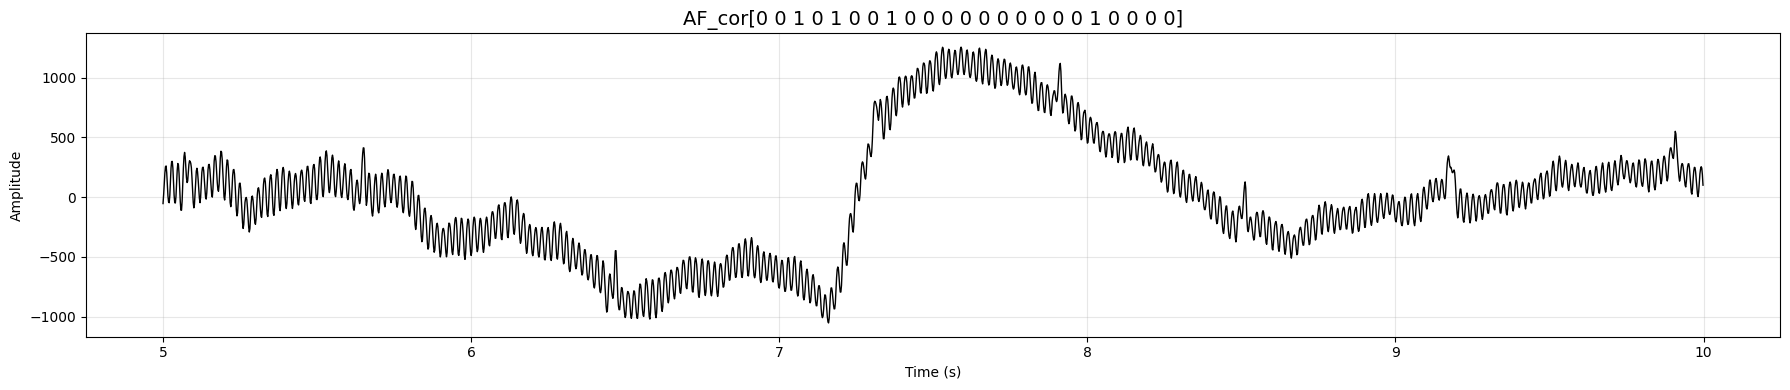

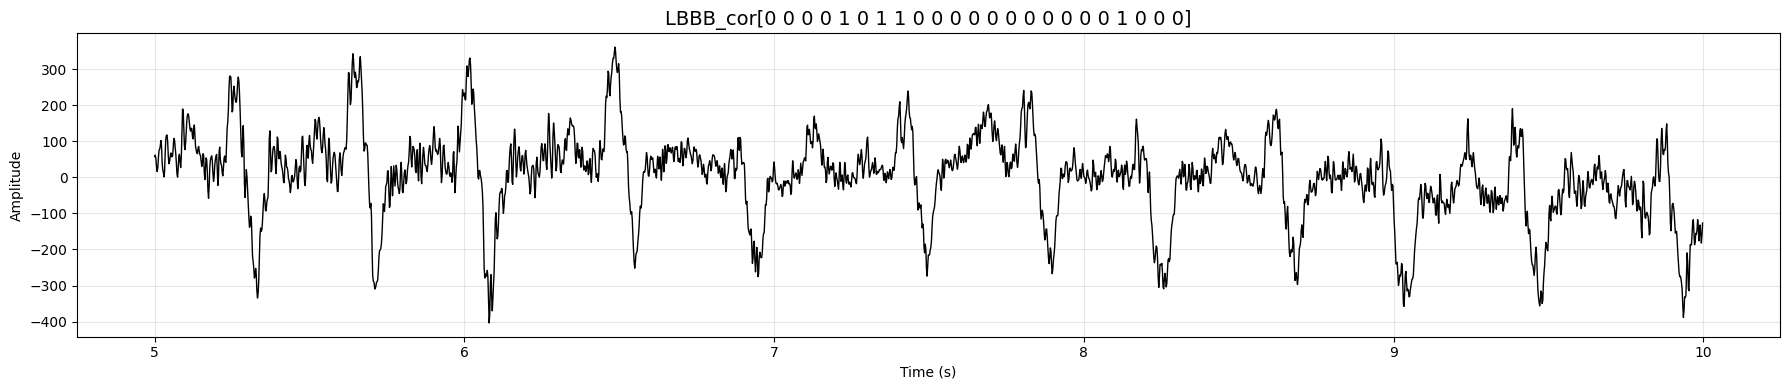

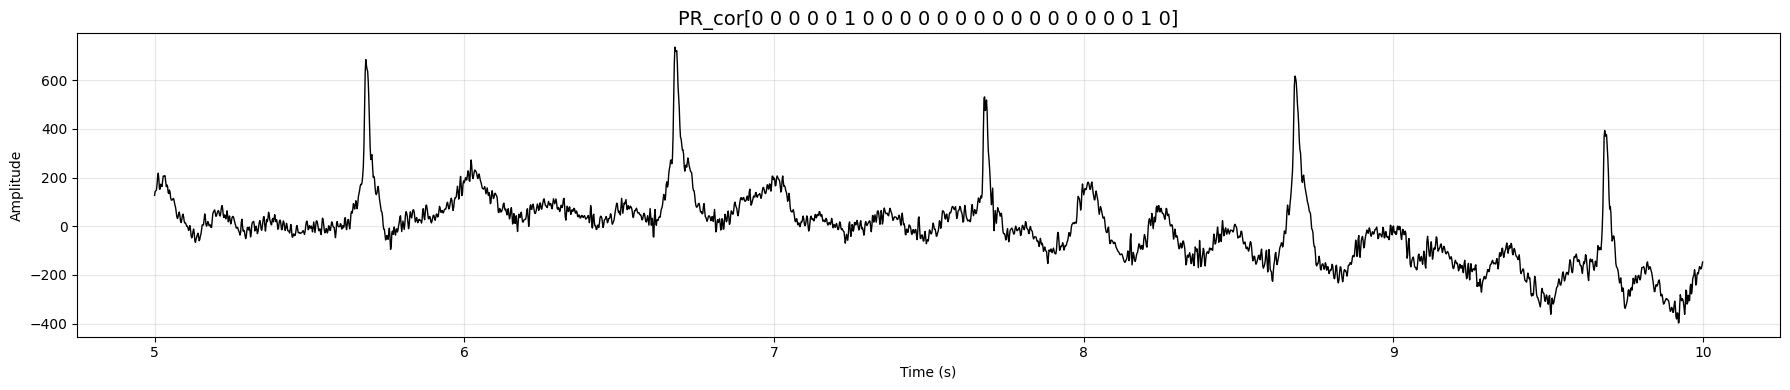

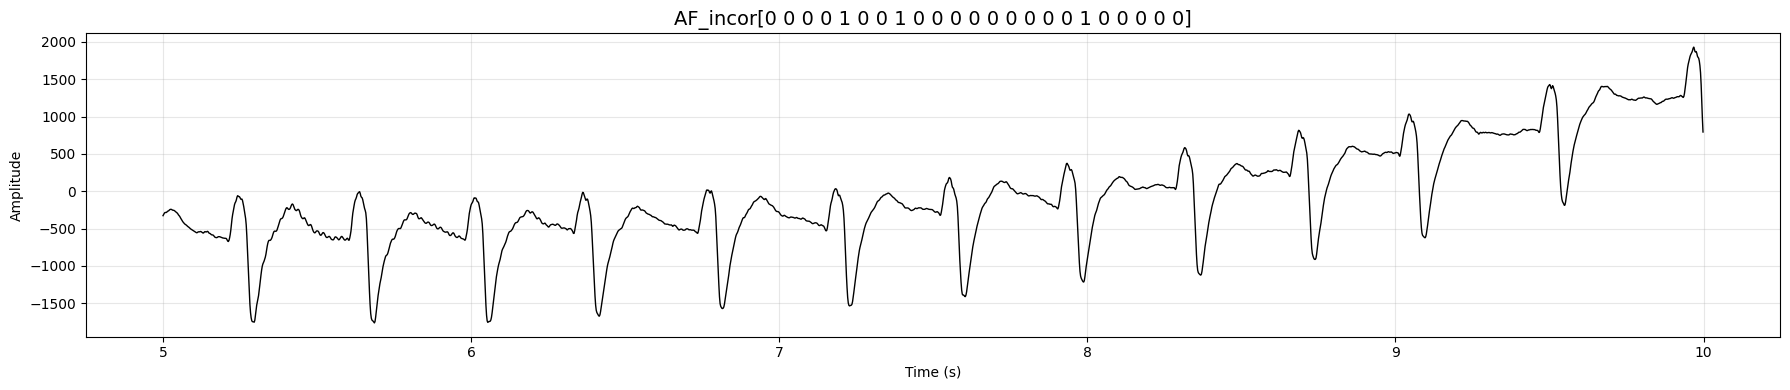

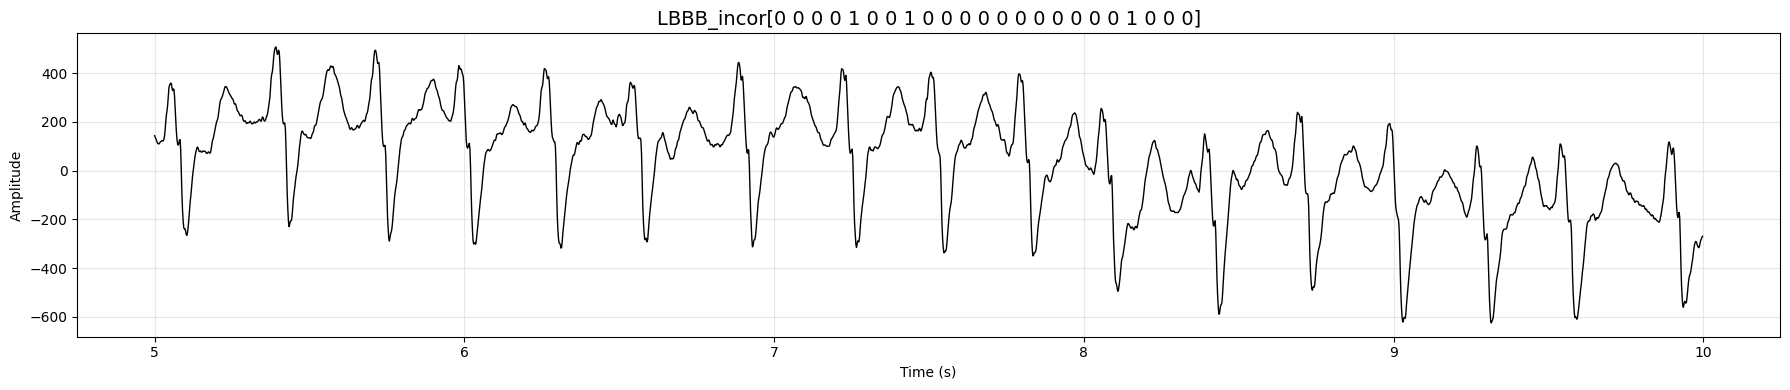

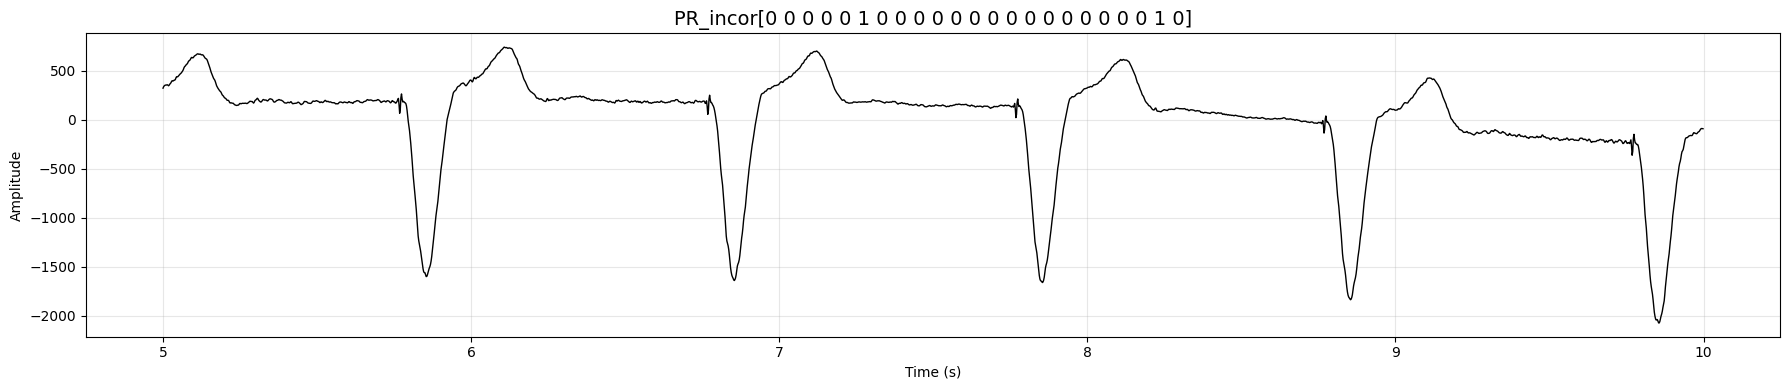

In [28]:

import os, re
import numpy as np
import matplotlib.pyplot as plt

def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs  # Nyquist 주파수 (샘플링 주파수의 절반)
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')  # Butterworth 밴드패스 필터 생성
    filtered_signal = filtfilt(b, a, signal)  # 필터 적용 (위상 왜곡 방지를 위해 filtfilt 사용)
    return filtered_signal

def plot_one_example(name, X, *, sid=0, lead_index=1, fs=500, seconds=10,
                     y , class_idx=None, proba=None, out_dir=None):
    """
    X: (N, L, T)
    name: 플롯 제목(간단히 질병명만) 예) 'AF_cor', 'AF_uncor'
    """
    N, L, T = X.shape
    X = np.asarray(X)
    if X.size == 0:
        print(f"[SKIP] {name}: 비어있는 그룹(X).")
        return

    x_limit = T if seconds is None else min(int(fs * seconds), T)
    tail_samples = x_limit // 2
    start_idx = max(0, x_limit - tail_samples)
    t =  np.arange(start_idx, x_limit) / fs
    sig = X[sid, lead_index, start_idx:x_limit]
    sig = bandpass_filter(sig, 0.05, 150, 500)
    
    plt.figure(figsize=(18, 4))
    plt.plot(t, sig, linewidth=1, color='black')
    plt.title(str(name)+f'{y[sid]}', fontsize=14)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


    plt.show()


sid = 0
'''2번 리드 인덱스 '''
lead = 1 
fs = 500
seconds = 10

# AF (cor)
plot_one_example(
    name="AF_cor",
    X=X_AF_cor, sid=sid, lead_index=lead, fs=fs, seconds=seconds,
    y=y_AF_cor, class_idx=AF_IDX, proba=None,
    out_dir='figure_AF_cor'
)

# LBBB (cor)
plot_one_example(
    name="LBBB_cor",
    X=X_LBBB_cor, sid=sid, lead_index=lead, fs=fs, seconds=seconds,
    y=y_LBBB_cor, class_idx=LBBB_IDX, proba=None,
    out_dir='figure_LBBB_cor'
)

# PR (cor) — p_PR_cor 사용
plot_one_example(
    name="PR_cor",
    X=X_PR_cor, sid=sid, lead_index=lead, fs=fs, seconds=seconds,
    y=y_PR_cor, class_idx=PR_IDX, proba=None
)

# AF (uncor)
plot_one_example(
    name="AF_incor",
    X=X_AF_uncor, sid=sid, lead_index=lead, fs=fs, seconds=seconds,
    y=y_AF_uncor, class_idx=AF_IDX, proba=None,
    out_dir='figure_AF_incor'
)

# LBBB (uncor)
plot_one_example(
    name="LBBB_incor",
    X=X_LBBB_uncor, sid=sid, lead_index=lead, fs=fs, seconds=seconds,
    y=y_LBBB_uncor, class_idx=LBBB_IDX, proba=None,
    out_dir='figure_LBBB_incor'
)

# PR (uncor) — p_PR_uncor 사용
plot_one_example(
    name="PR_incor",
    X=X_PR_uncor, sid=sid, lead_index=lead, fs=fs, seconds=seconds,
    y=y_PR_uncor, class_idx=PR_IDX, proba=None,
    out_dir='figure_PR_incor'
)




In [ ]:
# from team_code import process_data

# remove_list = ["BBB", "LPR", "Brady"]

# df_code = pd.read_csv('SNOMEDCTCode_Mapping.csv')
# df_code = df_code[~df_code["Abbreviation"].isin(remove_list)]
# class_list = df_code['SNOMEDCTCode'].to_list()

# classes = [item.split(',') if ',' in item else [item] for item in class_list]


# X_test_dx = [extract_dx(hea) for hea in y_test_all]
# # Process training data
# test_labels = process_data(X_test_dx, classes)

In [ ]:
# print(test_labels[:10])

In [ ]:
# print(all_results['DWT_model_12_leads_lr0.001_e21_valf10.38.h5']['DWT']['leads_12']['binary_prediction'][:10])

In [ ]:

import os
import re
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def calculate_metrics(test_labels, result, num_labels=23):
    metrics = {}
    
    for filter_type, filter_data in result.items():
        metrics[filter_type] = {}
        
        for leads_type, leads_data in filter_data.items():
            binary_prediction = np.array(leads_data['binary_prediction'])
            binary_prediction = np.squeeze(binary_prediction, axis=1)
            
            label_metrics = []
            for i in range(num_labels):
                y_true_label = test_labels[:, i]
                y_pred_label = binary_prediction[:, i]
                tn, fp, fn, tp = confusion_matrix(y_true_label, y_pred_label).ravel()
                
                accuracy = np.round((tp + tn) / (tp + tn + fp + fn), 5)
                precision = np.round(tp / (tp + fp) if (tp + fp) != 0 else 0, 5)
                recall = np.round(tp / (tp + fn) if (tp + fn) != 0 else 0, 5)
                f1score = np.round(2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0, 5)
                f2score = np.round(5 * precision * recall / (4 * precision + recall) if (4 * precision + recall) != 0 else 0, 5)
                
                label_metrics.append({
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1 Score': f1score,
                    'F2 Score': f2score
                })
            
            metrics[filter_type][leads_type] = label_metrics
    
    return metrics



In [ ]:
# test_labels가 문자열 리스트라면 numpy 배열로 변환
# if isinstance(test_labels, list) and isinstance(test_labels[0], str):
#     processed_test_labels = [np.fromstring(label.strip('[]'), sep=' ', dtype=int) for label in test_labels]
#     test_labels = np.array(processed_test_labels)
# elif isinstance(test_labels, list):
#     # 이미 리스트 형태이지만 문자열이 아니라면 numpy 배열로 변환
#     test_labels = np.array(test_labels)


In [ ]:
def compute_metrics_for_results(all_results, test_labels):
    metrics_results = {}

    for model_name, result in all_results.items():
        # result 구조: result[filter][num_leads]['binary_prediction']
        metrics = calculate_metrics(test_labels, result)
        metrics_results[model_name] = metrics

    return metrics_results

# 사용 예시

metrics_results = compute_metrics_for_results(all_results, y_test_all)
metrics_results_2 = compute_metrics_for_results(all_results_2, y_test_all)

# 결과 출력
print("\n=== Computed Metrics ===")
for model, metric_data in metrics_results.items():
    print(f"\nMetrics for model {model}:")
    for filter_type, filter_metrics in metric_data.items():
        for leads_type, leads_metrics in filter_metrics.items():
            print(f"{filter_type} - {leads_type}:")
            for label_index, label_metric in enumerate(leads_metrics):
                print(f"  Label {label_index}: {label_metric}")


=== Computed Metrics ===

Metrics for model PT_model_12_leads_lr0.001_e51_valf10.46.h5:
PT - leads_12:
  Label 0: {'Accuracy': 0.7993, 'Precision': 0.67023, 'Recall': 0.89958, 'F1 Score': 0.76815, 'F2 Score': 0.84196}
  Label 1: {'Accuracy': 0.94452, 'Precision': 0.82119, 'Recall': 0.98446, 'F1 Score': 0.89544, 'F2 Score': 0.94681}
  Label 2: {'Accuracy': 0.68033, 'Precision': 0.29663, 'Recall': 0.8438, 'F1 Score': 0.43895, 'F2 Score': 0.6164}
  Label 3: {'Accuracy': 0.97659, 'Precision': 0.84329, 'Recall': 0.97619, 'F1 Score': 0.90489, 'F2 Score': 0.94636}
  Label 4: {'Accuracy': 0.89086, 'Precision': 0.48384, 'Recall': 0.66708, 'F1 Score': 0.56087, 'F2 Score': 0.62011}
  Label 5: {'Accuracy': 0.90495, 'Precision': 0.5228, 'Recall': 0.83859, 'F1 Score': 0.64407, 'F2 Score': 0.7482}
  Label 6: {'Accuracy': 0.86176, 'Precision': 0.39357, 'Recall': 0.75858, 'F1 Score': 0.51826, 'F2 Score': 0.63989}
  Label 7: {'Accuracy': 0.91297, 'Precision': 0.40026, 'Recall': 0.60039, 'F1 Score': 0.4

In [ ]:
# # 사용 예시
# with tf.device('/device:GPU:1'):
#     if __name__ == "__main__":
#         base_path = r"/home/shjee/projects/ecg1d/model"
#         all_results = test_all_models(base_path, X_test_all)


In [ ]:
import pandas as pd


def save_metrics_to_excel(metrics_results, output_path, abbreviation_list=None):
    with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
        for model, metric_data in metrics_results.items():
            df_rows = []

            for filter_type, filter_metrics in metric_data.items():
                for leads_type, leads_metrics in filter_metrics.items():
                    for label_index, label_metric in enumerate(leads_metrics):
                        row = {}

                        # ✅ 병명 추가
                        if abbreviation_list and label_index < len(abbreviation_list):
                            row['Label'] = abbreviation_list[label_index]
                        else:
                            row['Label'] = f"Label_{label_index}"

                        row.update(label_metric)  # 메트릭 추가
                        df_rows.append(row)

            if df_rows:
                df = pd.DataFrame(df_rows)
                sheet_name = model[:31]  # Excel 시트 이름 제한 (31자)
                df.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"Metrics saved to {output_path}")


output_file = "model_metrics.xlsx"
output_file_2 = "model_metrics_2.xlsx"

with open('abbreviation_sorted.txt', 'r', encoding='utf-8') as f:
    abbreviation_list = [line.strip() for line in f.readlines()]
save_metrics_to_excel(metrics_results, output_file, abbreviation_list=abbreviation_list)


Metrics saved to model_metrics.xlsx


In [ ]:
with open('abbreviation_sorted.txt', 'r', encoding='utf-8') as f:
    abbreviation_list = [line.strip() for line in f.readlines()]
save_metrics_to_excel(metrics_results_2, output_file_2, abbreviation_list=abbreviation_list)

Metrics saved to model_metrics_2.xlsx


In [ ]:
!tensorboard --logdir=logs/fit --host=0.0.0.0 --port=6006

/bin/bash: /home/shjee/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
2025-08-13 09:11:34.487557: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 09:11:34.505276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755043894.522157 3514308 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755043894.526295 3514308 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-13 09:11:34.539500: I ten

In [ ]:


num_labels = 23


binary_prediction = np.array(result['Normal']['leads_12']['binary_prediction'])
binary_prediction = np.squeeze(binary_prediction, axis=1)

# 성능 지표를 저장할 리스트 초기화
metrics = []

# 각 레이블에 대한 성능 지표 계산
for i in range(num_labels):
    y_true_label = test_labels[:, i]
    y_pred_label = binary_prediction[:, i]

    tn, fp, fn, tp = confusion_matrix(y_true_label, y_pred_label).ravel()

    accuracy = np.round((tp + tn) / (tp + tn + fp + fn), 5)
    precision = np.round(tp / (tp + fp) if (tp + fp) != 0 else 0, 5)
    recall = np.round(tp / (tp + fn) if (tp + fn) != 0 else 0, 5)
    f1score = np.round(2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0, 5)
    f2score = np.round(5 * precision * recall / (4 * precision + recall) if (4 * precision + recall) != 0 else 0, 5)

    metrics.append((accuracy, precision, recall, f1score, f2score))

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])

# 데이터프레임 출력
print(metrics_df)


    Accuracy  Precision   Recall  F1 Score  F2 Score
0    0.95067    0.60218  0.73524   0.66209   0.70412
1    0.95367    0.74867  0.83990   0.79167   0.81992
2    0.99387    0.92373  0.73154   0.81648   0.76330
3    0.96958    0.76606  0.46518   0.57886   0.50484
4    0.97358    0.66136  0.82436   0.73392   0.78563
5    0.98160    0.77465  0.29570   0.42802   0.33742
6    0.93151    0.76601  0.40760   0.53208   0.44968
7    0.97734    0.82759  0.21918   0.34657   0.25696
8    0.98009    0.55556  0.03125   0.05917   0.03852
9    0.98147    0.85246  0.27225   0.41270   0.31515
10   0.97771    0.00000  0.00000   0.00000   0.00000
11   0.93039    0.94455  0.85847   0.89946   0.87441
12   0.96995    0.69027  0.47853   0.56522   0.50981
13   0.99474    0.96491  0.74324   0.83969   0.77903
14   0.99149    0.16667  0.01562   0.02856   0.01908
15   0.92989    0.65476  0.67073   0.66265   0.66747
16   0.97396    0.50000  0.14423   0.22388   0.16816
17   0.98523    0.72727  0.12500   0.21333   0

In [ ]:
def calculate_all_metrics(all_results, test_labels, num_labels=23):
    metrics_dict = {}

    for model_name, model_result in all_results.items():
        for filter_type, filter_result in model_result.items():
            for leads_type, result_data in filter_result.items():
                binary_prediction = np.array(result_data['binary_prediction'])
                binary_prediction = np.squeeze(binary_prediction, axis=1)
                
                metrics = []
                for i in range(num_labels):
                    y_true_label = test_labels[:, i]
                    y_pred_label = binary_prediction[:, i]

                    tn, fp, fn, tp = confusion_matrix(y_true_label, y_pred_label).ravel()

                    accuracy = np.round((tp + tn) / (tp + tn + fp + fn), 5)
                    precision = np.round(tp / (tp + fp) if (tp + fp) != 0 else 0, 5)
                    recall = np.round(tp / (tp + fn) if (tp + fn) != 0 else 0, 5)
                    f1score = np.round(2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0, 5)
                    f2score = np.round(5 * precision * recall / (4 * precision + recall) if (4 * precision + recall) != 0 else 0, 5)

                    metrics.append({
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Recall': recall,
                        'F1 Score': f1score,
                        'F2 Score': f2score
                    })
                
                metrics_dict[model_name] = {filter_type: {leads_type: metrics}}

    return metrics_dict

# 예제 실행
final_metrics = calculate_all_metrics(all_results, test_labels)
print(final_metrics)


TypeError: list indices must be integers or slices, not tuple

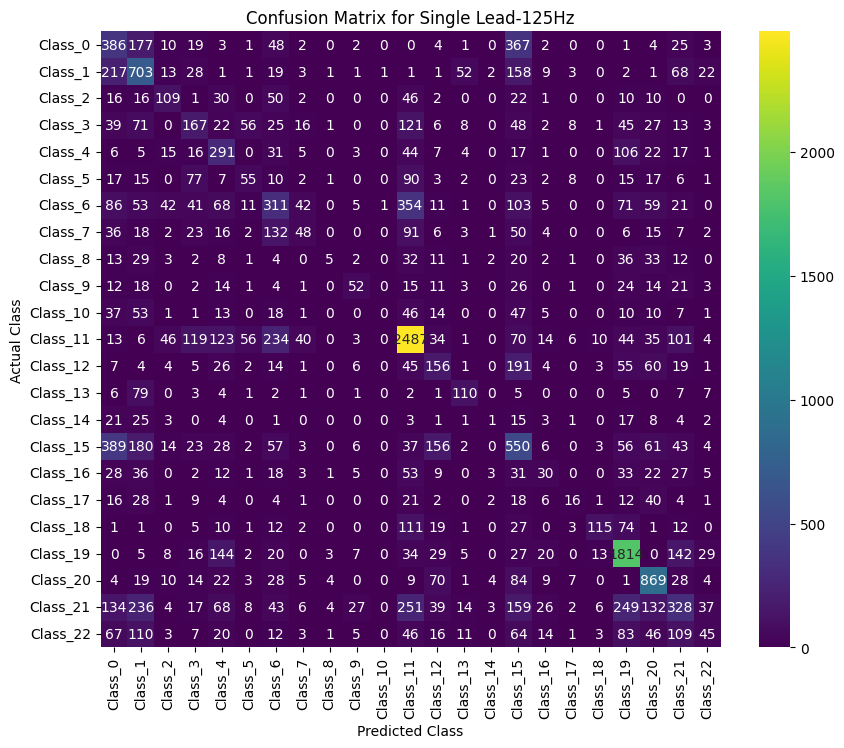

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


y_pred = np.array(binary_prediction)  # 예: (12071, 7)
y_true = np.array(test_labels)  # 예: (12071, 7)

# 레이블 수를 7로 조정
num_labels = 23

# 전체 혼동 행렬 초기화
total_cm = np.zeros((num_labels, num_labels))

# 각 클래스의 테스트 데이터 개수 계산
class_counts = np.sum(y_true, axis=0)

# 각 클래스별로 혼동 행렬 계산
for i in range(num_labels):
    for j in range(num_labels):
        # 실제 클래스 i에 대한 예측 클래스 j의 수
        count = np.sum((y_true[:, i] == 1) & (y_pred[:, j] == 1))
        # 클래스 개수로 나누어 보정
        total_cm[i, j] = count

# 혼동 행렬을 데이터프레임으로 변환
cm_df = pd.DataFrame(total_cm, columns=[f'Class_{j}' for j in range(num_labels)], index=[f'Class_{i}' for i in range(num_labels)])

# 시각화
plt.figure(figsize=(10, 8))  # 크기 조정
sns.heatmap(cm_df, annot=True, fmt="g", cmap="viridis")  # cmap 추가
plt.title('Confusion Matrix for Single Lead-125Hz')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()